In [16]:
# Default style guide
from matplotlib import style
style.use('fivethirtyeight')

# Import the dependencies
import pandas as pd
import numpy as np
import datetime as dt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base


# Reflect Tables into SQLAlchemy ORM

In [17]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [18]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [19]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [20]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [31]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create a session
session = Session(engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [42]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
query = text("""SELECT
                id,
                station,
                date,
                prcp
            FROM
                measurement
            WHERE
                date >= '2016-08-23'
            ORDER BY
                date;""")
prcp_df = pd.read_sql(query,con=conn)
# Sort the dataframe by date
prcp_df1 = df.sort_values(by="date")
prcp_df1.head()


,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


In [67]:
#ORM
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
prcp_df1a = pd.DataFrame(rows)
prcp_df1a.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


<Figure size 1000x1200 with 0 Axes>

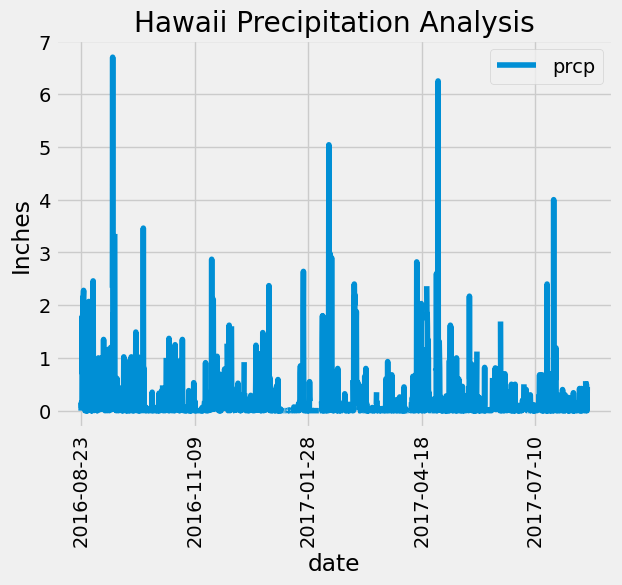

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,12))
prcp_df1.plot(x="date", y="prcp", rot=90)
plt.title("Hawaii Precipitation Analysis")
plt.ylabel("Inches")
plt.show()

In [60]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df1.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number of stations in the dataset
query = text("""SELECT count(station) from station;""")
conn.execute(query).fetchall()

[(9,)]

In [64]:
session.query(func.count(Station.station)).all()

[(9,)]

In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = text("""SELECT
                    station,
                    count(id) as num_observations
                FROM
                    measurement
                GROUP BY
                    station
                ORDER BY
                    num_observations desc;""")
station_df = pd.read_sql(query, con=conn)
station_df.head(10)

,station,num_observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [68]:
#ORM
rows = session.query(
    Measurement.station,
    func.count(Measurement.id).label('num_observations')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all() # help from chatgpt
station_dfa = pd.DataFrame(rows)
station_dfa.head(10)

,station,num_observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [70]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = text("""SELECT
                    min(tobs) as min_tobs,
                    max(tobs) as max_tobs,
                    avg(tobs) as avg_tobs
                FROM
                    measurement
                WHERE
                    station = 'USC00519281';""")
station_df2 = pd.read_sql(query, con=conn)
station_df2.head(10)

,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


In [72]:
#ORM
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [82]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
query = text("""SELECT
                    id,
                    station,
                    date,
                    tobs
                FROM
                    measurement
                WHERE
                    station = 'USC00519281'
                    and date >= '2016-08-23'
                ORDER BY
                    date;""")
temp_df = pd.read_sql(query, con=conn)
temp_df.head()

ResourceClosedError: This Connection is closed

In [75]:
#ORM
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
temp_dfa = temp_dfa = pd.DataFrame(rows)
temp_dfa.head()

,id,station,date,tobs
0,14608,USC00519281,2016-08-23,77.0
1,14609,USC00519281,2016-08-24,77.0
2,14610,USC00519281,2016-08-25,80.0
3,14611,USC00519281,2016-08-26,80.0
4,14612,USC00519281,2016-08-27,75.0


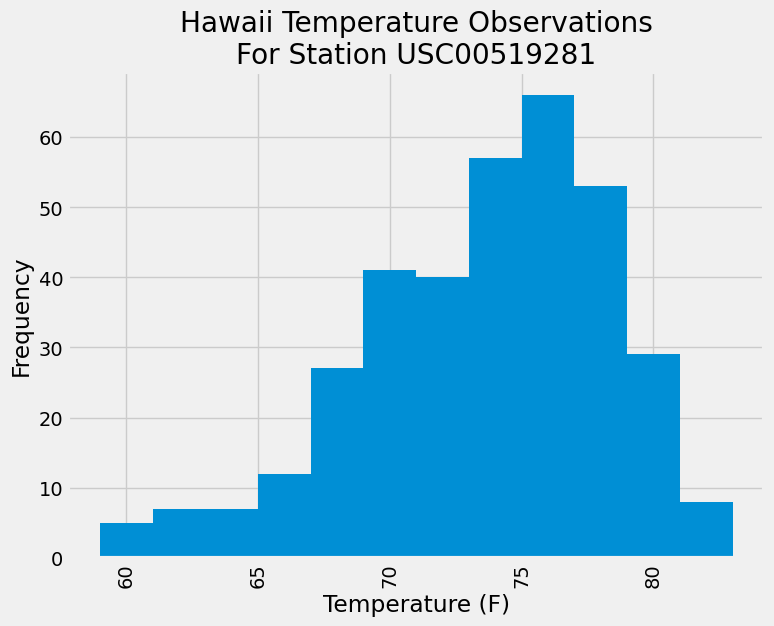

In [79]:
# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temp_dfa.tobs, bins=12)
plt.title("Hawaii Temperature Observations\nFor Station USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

# Close Session

In [80]:
# Close Session
session.close()
conn.close()

In [81]:
engine.dispose()